In [1]:
!git clone https://github.com/Satvik01000/Noise-Classification-and-Cancelation

Cloning into 'Noise-Classification-and-Cancelation'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 33 (delta 8), reused 4 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (33/33), 23.73 MiB | 17.67 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [2]:
import tensorflow as tf

classifier = tf.keras.models.load_model('/content/Noise-Classification-and-Cancelation/best_classifier.keras')
mrdnn = tf.keras.models.load_model('/content/Noise-Classification-and-Cancelation/best_mrdnn.keras')

In [3]:
!pip install pystoi

In [4]:
import numpy as np
from pystoi import stoi
import matplotlib.pyplot as plt

def compute_snr(clean, processed):
    noise = clean - processed
    return 10 * np.log10(np.sum(clean**2) / (np.sum(noise**2) + 1e-10))

def compute_stoi(clean, processed, fs=16000):
    return stoi(clean, processed, fs, extended=False)

In [5]:
!git clone https://github.com/microsoft/MS-SNSD.git

Cloning into 'MS-SNSD'...
remote: Enumerating objects: 29924, done.
remote: Total 29924 (delta 0), reused 0 (delta 0), pack-reused 29924 (from 1)
Receiving objects: 100% (29924/29924), 3.93 GiB | 20.78 MiB/s, done.
Resolving deltas: 100% (81/81), done.
Updating files: 100% (24399/24399), done.


In [6]:
!pip install librosa

In [7]:
import librosa
import os

In [10]:
clean_dir = "/content/MS-SNSD/clean_test"
noisy_dir = "/content/MS-SNSD/noise_test"

In [11]:
clean_files = sorted(os.listdir(clean_dir))
noisy_files = sorted(os.listdir(noisy_dir))

print("Total test samples:", len(clean_files))

Total test samples: 1101


In [19]:
def denoise_audio_array(audio, model):
    N_FFT = 255
    HOP_LEN = 125
    CHUNK_FRAMES = 128

    chunk_len = CHUNK_FRAMES * HOP_LEN
    padding = chunk_len - (len(audio) % chunk_len)
    padded_audio = np.pad(audio, (0, padding))

    full_spec = librosa.stft(padded_audio, n_fft=N_FFT, hop_length=HOP_LEN)
    full_mag, full_phase = librosa.magphase(full_spec)

    num_chunks = full_mag.shape[1] // CHUNK_FRAMES
    predicted_mags = []

    for i in range(num_chunks):
        seg_mag = full_mag[:, i*CHUNK_FRAMES:(i+1)*CHUNK_FRAMES]

        log_mag = np.log1p(seg_mag)
        input_chunk = log_mag.T[np.newaxis, ..., np.newaxis]

        pred = model.predict(input_chunk, verbose=0)
        pred_linear = np.expm1(pred.squeeze().T)

        predicted_mags.append(pred_linear)

    predicted_full_mag = np.hstack(predicted_mags)

    noisy_mag_crop = full_mag[:, :predicted_full_mag.shape[1]]
    noisy_spec_crop = full_spec[:, :predicted_full_mag.shape[1]]

    mask = predicted_full_mag / (noisy_mag_crop + 1e-10)
    mask = np.clip(mask, 0.05, 1.0)

    clean_spec_complex = noisy_spec_crop * mask
    y_reconstructed = librosa.istft(clean_spec_complex, hop_length=HOP_LEN)

    return y_reconstructed

In [20]:
def load_audio(path, sr=16000):
    signal, _ = librosa.load(path, sr=sr)
    return signal

In [21]:
snr_before = []
snr_after = []
stoi_before = []
stoi_after = []

num_samples = 10

for i in range(num_samples):

    if clean_files[i] == 'Readme.md':
        continue

    clean_path = os.path.join(clean_dir, clean_files[i])
    noisy_path = os.path.join(noisy_dir, noisy_files[i])

    clean = load_audio(clean_path)
    noisy = load_audio(noisy_path)

    min_len = min(len(clean), len(noisy))
    clean = clean[:min_len]
    noisy = noisy[:min_len]

    # 🔥 Correct denoising
    denoised = denoise_audio_array(noisy, mrdnn)

    min_len = min(len(clean), len(denoised))
    clean = clean[:min_len]
    noisy = noisy[:min_len]
    denoised = denoised[:min_len]

    snr_before.append(compute_snr(clean, noisy))
    snr_after.append(compute_snr(clean, denoised))

    stoi_before.append(compute_stoi(clean, noisy))
    stoi_after.append(compute_stoi(clean, denoised))

print("Evaluation Complete ✅")

Evaluation Complete ✅


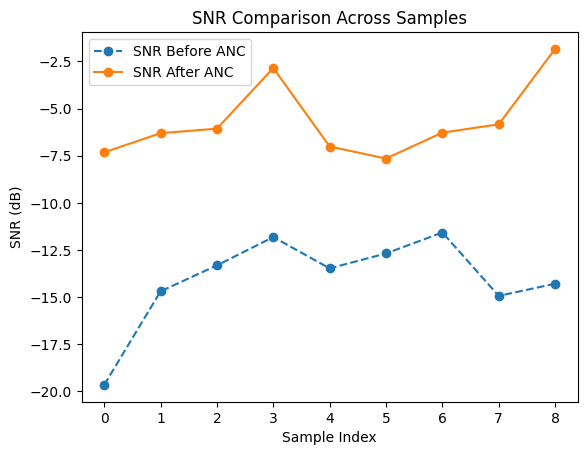

In [22]:
plt.figure()
plt.plot(snr_before, '--o', label="SNR Before ANC")
plt.plot(snr_after, '-o', label="SNR After ANC")
plt.xlabel("Sample Index")
plt.ylabel("SNR (dB)")
plt.title("SNR Comparison Across Samples")
plt.legend()
plt.show()

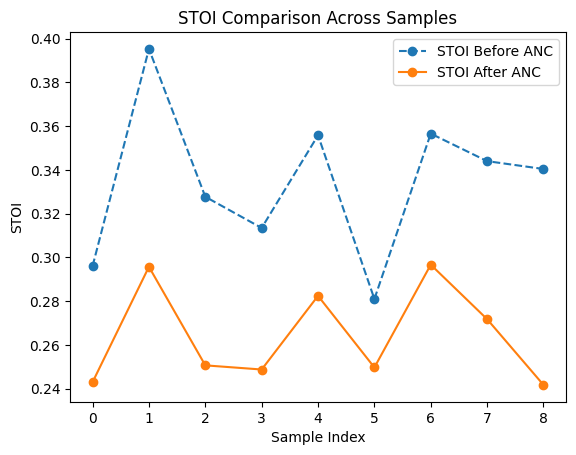

In [23]:
plt.figure()
plt.plot(stoi_before, '--o', label="STOI Before ANC")
plt.plot(stoi_after, '-o', label="STOI After ANC")
plt.xlabel("Sample Index")
plt.ylabel("STOI")
plt.title("STOI Comparison Across Samples")
plt.legend()
plt.show()

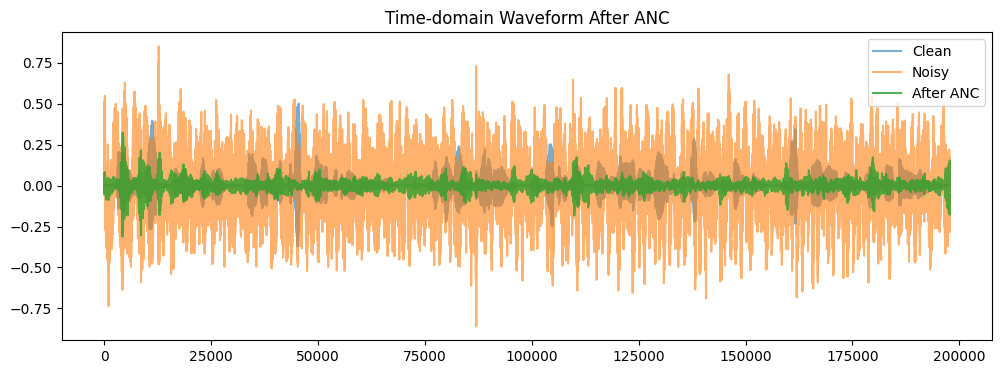

In [24]:
plt.figure(figsize=(12,4))
plt.plot(clean, alpha=0.6, label="Clean")
plt.plot(noisy, alpha=0.6, label="Noisy")
plt.plot(denoised, alpha=0.8, label="After ANC")
plt.title("Time-domain Waveform After ANC")
plt.legend()
plt.show()